In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Parameters from the C++ config
params_c4_reference = {
    "sampling": 10.0,
    "smoothing_L": 500.0,
    "MWD_length": 800.0,
    "decay_time": 11000.0,
    "MWD_trace_start": 3000.0,
    "MWD_trace_stop": 5000.0,
    "MWD_amp_start": 4100.0,
    "MWD_amp_stop": 4200.0,
    "MWD_baseline_start": 3000.0,
    "MWD_baseline_stop": 3300.0,
}

In [22]:
# Load full data for a single channel
df = pd.read_csv("../data/test_0010_csv/board0_ch13.csv")
time_cols = [c for c in df.columns if c.startswith("t")]
waveforms = df[time_cols].values
original_energies = df["energy"].values
original_MWD = df["MWD"].values

In [23]:
def compute_mwd_trace_and_energy(trace, params, baseline_corr=True):
    """
    Faithful Python translation of MWD algorithm from LisaRaw2Ana.cxx
    """

    sampling = params["sampling"]
    smoothing_L = params["smoothing_L"]
    MWD_length = params["MWD_length"]
    decay_time = params["decay_time"]

    # Index conversions
    LL = int(smoothing_L / sampling)
    MM = int(MWD_length / sampling)
    tau = decay_time / sampling

    k0 = int(params["MWD_trace_start"] / sampling)
    kend = int(params["MWD_trace_stop"] / sampling)

    amp_start_idx = int(params["MWD_amp_start"] / sampling) - k0
    amp_stop_idx = int(params["MWD_amp_stop"] / sampling) - k0
    baseline_start_idx = int(params["MWD_baseline_start"] / sampling) - k0
    baseline_stop_idx = int(params["MWD_baseline_stop"] / sampling) - k0

    # --- Corrected baseline calculation: samples 20 to 149 ---
    if baseline_corr:
        baseline = np.mean(trace[20:150])
    else:
        baseline = 0.0

    trace_febex_0 = (np.array(trace) - baseline) / 8.0

    # --- MWD trace calculation ---
    trace_mwd = []
    for kk in range(k0, min(kend, len(trace))):
        DM = 0.0
        sum0 = None
        for j in range(kk - LL, kk):
            if j < 1 or (j - MM) < 0 or j >= len(trace_febex_0):
                continue
            if sum0 is None:
                sum0 = np.sum(trace_febex_0[max(0, j - MM):j])
            else:
                if (j - MM - 1) >= 0:
                    sum0 -= trace_febex_0[j - MM - 1]
                sum0 += trace_febex_0[j - 1]
            DM += trace_febex_0[j] - trace_febex_0[j - MM] + sum0 / tau
        trace_mwd.append(DM / LL)

    trace_mwd = np.array(trace_mwd)

    # --- Energy extraction (flat top - baseline window) ---
    if (
        amp_stop_idx > len(trace_mwd)
        or baseline_stop_idx > len(trace_mwd)
        or amp_start_idx < 0
        or baseline_start_idx < 0
    ):
        return np.nan, trace_mwd, trace_febex_0

    energy_flat = np.mean(trace_mwd[amp_start_idx:amp_stop_idx])
    energy_base = np.mean(trace_mwd[baseline_start_idx:baseline_stop_idx])
    energy = abs(energy_flat - energy_base)

    return energy, trace_mwd, trace_febex_0


In [26]:
def plot_mwd_diagnostics(i, params=params_c4_reference):
    # Compute Python values
    energy_py, trace_mwd_py, trace_febex_0 = compute_mwd_trace_and_energy(waveforms[i], params)

    # Get C++ baseline subtraced trace from CSV file
    base_cols = [c for c in df.columns if c.startswith("b")]
    trace_0_cpp = df.loc[i, base_cols].values

    # Get C++ MWD trace from CSV file
    mwd_cols = [c for c in df.columns if c.startswith("m")]
    trace_mwd_cpp = df.loc[i, mwd_cols].values

    # Get original trace from CSV for raw (optional, fallback)
    trace_raw = waveforms[i]

    # Get energy from file
    energy_cpp = original_MWD[i]

    # Sample indices
    sampling = params["sampling"]
    k0 = int(params["MWD_trace_start"] / sampling)
    amp_start_idx = int(params["MWD_amp_start"] / sampling) - k0
    amp_stop_idx = int(params["MWD_amp_stop"] / sampling) - k0

    # Flatness of Python MWD flat-top region
    if 0 <= amp_start_idx < amp_stop_idx <= len(trace_mwd_py):
        flat_top = trace_mwd_py[amp_start_idx:amp_stop_idx]
        flatness = np.std(flat_top) / np.mean(flat_top)
    else:
        flatness = np.nan

    # --- Plot ---
    fig, axs = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

    axs[0].plot(trace_raw, label="Raw Trace")
    axs[0].set_title(f"Event {i}: Raw Trace")
    axs[0].legend(); axs[0].grid(True)

    axs[1].plot(trace_0_cpp, label="Baseline-Subtracted Trace from C++ (file)", linestyle="--", color="gray")
    axs[1].plot(trace_febex_0, label="Baseline-Subtracted Trace", color="orange")
    axs[1].set_title("Trace after Baseline Subtraction")
    axs[1].legend(); axs[1].grid(True)

    axs[2].plot(trace_mwd_cpp, label="MWD from C++ (file)", linestyle="--", color="gray")
    axs[2].plot(trace_mwd_py, label="MWD from Python", color="green")
    axs[2].axvspan(amp_start_idx, amp_stop_idx, color="red", alpha=0.2, label="Flat-top window")
    axs[2].set_title("MWD Trace Comparison")
    axs[2].legend(); axs[2].grid(True)
    axs[2].set_xlabel("Sample index (relative to k0)")

    plt.tight_layout()
    plt.show()

    print(f"Energy from C++ (file):      {energy_cpp:.4f}")
    print(f"Energy from Python:          {energy_py:.4f}")
    print(f"Flatness of Python flat-top: {flatness:.4f} (std / mean)")

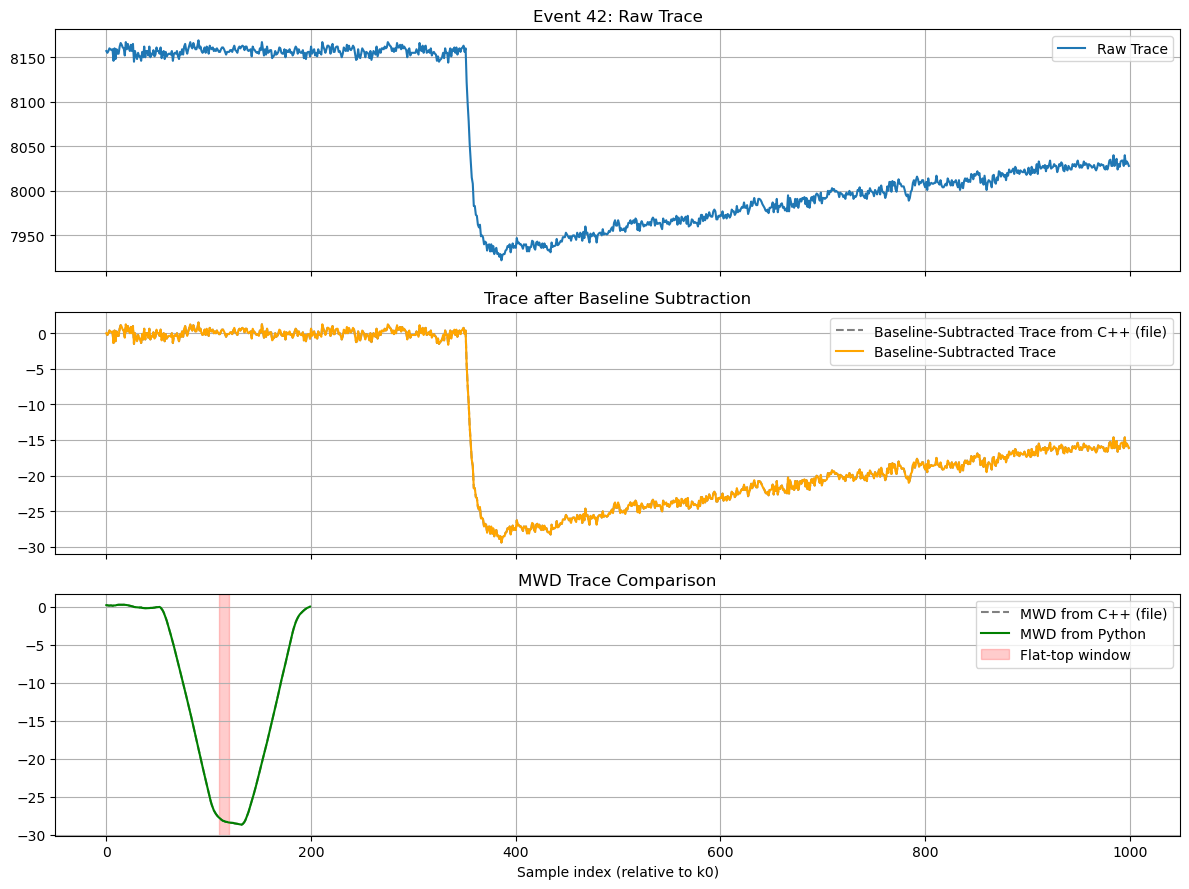

Energy from C++ (file):      28.2509
Energy from Python:          28.2509
Flatness of Python flat-top: -0.0072 (std / mean)


In [27]:
plot_mwd_diagnostics(42)